# For this project, let's assume that we are a business who sells a very unique product. We provide our customers with a recommended team of players for their Premier League Fantasy teams. Our recommended team aims to maximize the number of fantasy game points that the customer will receive over the course of the current Premier League season while keeping to a total budget of £100 million. A standard Premier League season consists of 38 gameweeks and typically runs from early-August to early-May. We will use our football and fantasy football domain knowledge to guide the data analysis.

-------------------------------------------------------------------------------------------------------

# In this notebook we will:
# - Call the Premier League Fantasy Football API
# - Compile the team and player data into dataframes
# - Visualize the relevant data and draw meaningful insight
# - Influence final business/product decisions

-------------------------------------------------------------------------------------------------------

### Let's begin by importing useful modules and configuring this Jupyter notebook to display all rows and columns of a dataframe.

In [1]:
import requests
import json
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

pd.options.display.max_columns = None
pd.options.display.max_rows = None

### These are some of the available API's that we can retrieve football data from. The English Premier League (EPL) hosts a Fantasy API and we will be using this for the 2018/2019 and 2019/2020 seasons. Note that I already have the 18/19 data saved on my computer as a .json file, so I put the path to that file here.

In [2]:
api_other = 'https://api.football-data.org/v2/competitions'
api_18_19 = 'season_18_19/season_18_19.json'
api_19_20 = 'https://fantasy.premierleague.com/api/bootstrap-static/'

### Let's define a function that will perform the API call and return the football data that we are after with .json formatting. Some API's require that you have an API-key to access their data. If this is the case, such as with the *api_other* link, you will need to request one and save the API-key in a local file called *secrets.yml*. This file should be placed in the same working directory as this notebook before calling this function.

In [3]:
def get_api_json(api_url, api_code=False, print_keys=True):
    
    headers = {
        'Accept': "*/*",
        'Cache-Control': "no-cache",
        'accept-encoding': "gzip, deflate",
        'Connection': "keep-alive",
        'cache-control': "no-cache"
        }
    
    if api_code:
        import yaml
        with open("secrets.yml", 'r') as f:
            try: api_code = yaml.safe_load(f)
            except yaml.YAMLError as exc: print(exc)
        headers['X-Auth-Token'] = api_code

    response = requests.request("GET", api_url, headers=headers)
    response_json = response.json()
    if print_keys: print(response_json.keys())
    
    return response_json

### Let's define a similar function which reads in a local .json file rather than requesting one from a server.

In [4]:
def get_local_json(json_file, encoding="utf8", print_keys=True):
    with open(json_file, 'r', encoding=encoding) as f:
        json_out = json.load(f)
    if print_keys: print(json_out.keys())
    
    return json_out

### Since I have the 18/19 season data already downloaded locally, I will load the .json file using the local function. For the 19/20 season, I will request the data from the API server using the API function. Note that calls to this EPL Fantasy API don't require API-keys.

In [5]:
json_18_19 = get_local_json(api_18_19)

dict_keys(['phases', 'elements', 'stats', 'game-settings', 'current-event', 'total-players', 'teams', 'element_types', 'last-entry-event', 'stats_options', 'next_event_fixtures', 'events', 'next-event'])


In [6]:
json_19_20 = get_api_json(api_19_20, api_code=True)

dict_keys(['events', 'game_settings', 'phases', 'teams', 'total_players', 'elements', 'element_stats', 'element_types'])


### Because .json files are formatted in the form of nested dictionaries, we can use pandas to create dataframes from these dictionaries directly. For each of the 18/19 and 19/20 seasons, we will create separate dataframes for player data, team data, gamweek data, and monthly schedule data. 

In [7]:
players18 = pd.DataFrame.from_dict(json_18_19['elements'])
teams18 = pd.DataFrame.from_dict(json_18_19['teams'])
gmwks18 = pd.DataFrame.from_dict(json_18_19['events'])
months18 = pd.DataFrame.from_dict(json_18_19['phases'])

players19 = pd.DataFrame.from_dict(json_19_20['elements'])
teams19 = pd.DataFrame.from_dict(json_19_20['teams'])
gmwks19 = pd.DataFrame.from_dict(json_19_20['events'])
months19 = pd.DataFrame.from_dict(json_19_20['phases'])

positions = pd.DataFrame.from_dict(json_19_20['element_types'])

### For reference, let's have a quick look at what is contained in our players dataframe for the 18/19 season. We can see that there are 624 players this season and, at least for the columns we are interested in, the player data does not require further cleaning.

In [8]:
players18.head()

,id,photo,web_name,team_code,status,code,first_name,second_name,squad_number,news,now_cost,news_added,chance_of_playing_this_round,chance_of_playing_next_round,value_form,value_season,cost_change_start,cost_change_event,cost_change_start_fall,cost_change_event_fall,in_dreamteam,dreamteam_count,selected_by_percent,form,transfers_out,transfers_in,transfers_out_event,transfers_in_event,loans_in,loans_out,loaned_in,loaned_out,total_points,event_points,points_per_game,ep_this,ep_next,special,minutes,goals_scored,assists,clean_sheets,goals_conceded,own_goals,penalties_saved,penalties_missed,yellow_cards,red_cards,saves,bonus,bps,influence,creativity,threat,ict_index,ea_index,element_type,team
0,1,11334.jpg,Cech,3,a,11334,Petr,Cech,1.0,,47,2018-09-29T17:31:14Z,100.0,100.0,0.0,5.1,-3,0,3,0,False,0,1.1,0.0,136211,83497,0,0,0,0,0,0,24,0,3.4,0.5,0.5,False,585,0,0,1,9,0,0,0,0,0,27,3,130,205.0,0.0,0.0,20.4,0,1,1
1,2,80201.jpg,Leno,3,a,80201,Bernd,Leno,19.0,,49,None,NaN,NaN,0.0,21.6,-1,0,1,0,False,1,4.0,0.0,250834,339095,0,0,0,0,0,0,106,3,3.3,0.5,3.7,False,2835,0,0,6,42,0,0,0,0,0,105,5,568,807.2,0.0,0.0,80.5,0,1,1
2,3,51507.jpg,Koscielny,3,a,51507,Laurent,Koscielny,6.0,,54,2019-05-03T08:31:19Z,100.0,100.0,0.0,11.5,-1,0,1,0,False,1,0.9,0.0,92187,128478,0,0,0,0,0,0,62,1,3.6,0.5,2.7,False,1329,3,0,3,23,0,0,0,1,0,0,8,319,456.4,29.5,105.0,59.1,0,2,1
3,4,98745.jpg,Bellerín,3,i,98745,Héctor,Bellerín,2.0,Knee injury - Unknown return date,53,2019-01-19T20:01:19Z,0.0,0.0,0.0,11.3,-2,0,2,0,False,0,4.5,0.0,1143684,567084,0,0,0,0,0,0,60,0,3.2,0.0,0.0,False,1532,0,5,4,21,1,0,0,3,0,0,5,304,261.6,197.8,280.0,73.7,0,2,1
4,5,38411.jpg,Monreal,3,a,38411,Nacho,Monreal,18.0,,54,2019-04-28T10:31:25Z,100.0,100.0,0.0,14.3,-1,0,1,0,False,1,1.3,0.0,290921,298216,0,0,0,0,0,0,77,2,3.5,0.5,3.3,False,1860,1,4,5,24,0,0,0,5,0,0,7,392,413.2,196.6,224.0,83.4,0,2,1


In [9]:
players18.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 624 entries, 0 to 623
Data columns (total 58 columns):
id                              624 non-null int64
photo                           624 non-null object
web_name                        624 non-null object
team_code                       624 non-null int64
status                          624 non-null object
code                            624 non-null int64
first_name                      624 non-null object
second_name                     624 non-null object
squad_number                    612 non-null float64
news                            624 non-null object
now_cost                        624 non-null int64
news_added                      494 non-null object
chance_of_playing_this_round    494 non-null float64
chance_of_playing_next_round    494 non-null float64
value_form                      624 non-null object
value_season                    624 non-null object
cost_change_start               624 non-null int64
cost_change_e

### Let's use this dataframe to get a better understanding of how the Premier League teams performed during the 18/19 season. We will create a new dataframe for each team and denote their total fantasy points, total player costs, and return on investment (ROI). The ROI is defined as the number of fantasy points earned per million £ (total fantasy points / total player costs).

In [10]:
total_points_byteam = players18.groupby('team')['total_points'].sum().reset_index(drop=True)
players18['now_cost'] = players18['now_cost']/10 #convert to fantasy prices in millions
total_cost_byteam = players18.groupby('team')['now_cost'].sum().reset_index(drop=True)
team_df = pd.concat([teams18['id'], teams18['name'], total_points_byteam, total_cost_byteam, total_points_byteam/total_cost_byteam], axis=1, keys=['id', 'name', 'total_points', 'total_cost', 'team_roi'])

In [11]:
team_df.head(20)

,id,name,total_points,total_cost,team_roi
0,1,Arsenal,1644,172.2,9.547038
1,2,Bournemouth,1500,151.5,9.900990
2,3,Brighton,1265,145.6,8.688187
3,4,Burnley,1322,143.0,9.244755
4,5,Cardiff,1355,138.1,9.811731
5,6,Chelsea,1881,174.1,10.804136
6,7,Crystal Palace,1582,153.1,10.333116
7,8,Everton,1677,167.8,9.994041
8,9,Fulham,1135,143.2,7.925978
9,10,Huddersfield,1073,153.1,7.008491


### A plot of the team ROI will help us visualize which Premier League teams are investing well (at least in the fantasy football domain). We can sort these from largest to smallest and see a correlation with their place in the Premier League table (in the real world domain). Teams like Wolves and Crystal Palace seem to perform better than expected in this regard, while teams like Manchester United and Arsenal perform worse than expected.

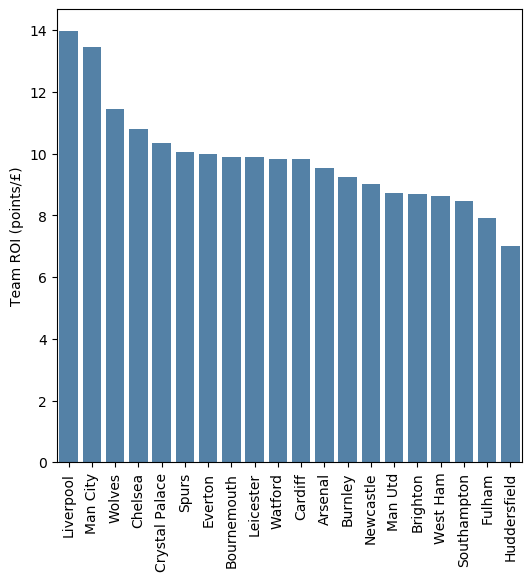

In [12]:
team_df = team_df.sort_values(['team_roi'], ascending=False).reset_index(drop=True)
fig, ax = plt.subplots(1, 1, figsize = (6, 6), dpi=100)
g = sns.barplot(x="name", y="team_roi", data=team_df, color='steelblue')
for item in g.get_xticklabels():
    item.set_rotation(90)
ax.set_xlabel('')
ax.set_ylabel('Team ROI (points/£)')
plt.show()

### If you are familiar with competitive football, you may be aware that teams often do not use all of their players. Some players may not play the entire season and others may only play as substitutes for a few minutes at the end of matches. For this reason, we can get a better gauge of a team's fantasy league performance if we normalize the ROI by the number of "main" players in their team. This will disregard the fantasy points and costs related to players who rarely play.

In [13]:
players18_main = players18[players18['minutes'] > 450]
players18_main_byteam = players18_main.groupby('team')['minutes'].count().reset_index(drop=True)
team_df['players_main'] = players18_main_byteam
team_df['team_roi_perplayer'] = team_df['team_roi']/team_df['players_main']
team_df = team_df.sort_values(['team_roi_perplayer'], ascending=False).reset_index(drop=True)

### The team ROI per main player is defined as the number of fantasy points earned per million £ per player who plays more than 450 minutes in a season (total fantasy points / total player costs / number of players who play more than 450 minutes).

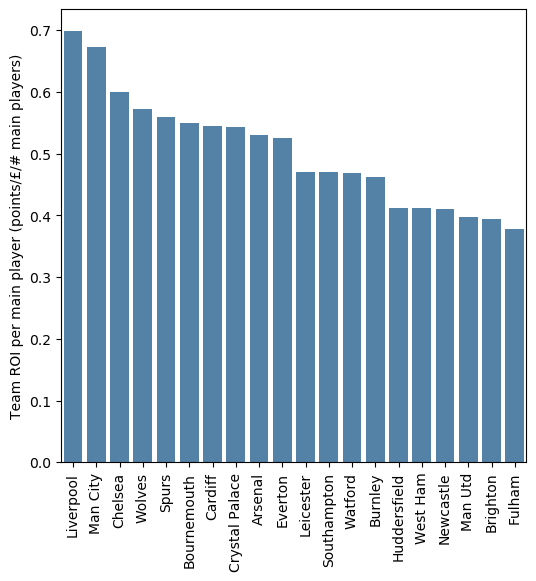

In [14]:
fig, ax = plt.subplots(1, 1, figsize = (6, 6), dpi=100)
g = sns.barplot(x="name", y="team_roi_perplayer", data=team_df, color='steelblue')
for item in g.get_xticklabels():
    item.set_rotation(90)
ax.set_xlabel('')
ax.set_ylabel('Team ROI per main player (points/£/# main players)')
plt.show()

### Now that we have an idea of which teams we should buy from, let's look into the actual players. First we add a column to our player dataframe for the player ROI, defined in the same way as before.

In [15]:
def get_team_name(row):
    return teams18[teams18['id'] == row['team']]['name'].item()

In [16]:
players18['player_roi'] = players18['total_points'] / players18['now_cost']
players18['team_name'] = players18.apply(lambda row: get_team_name(row), axis=1)

c:\users\winte\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: `item` has been deprecated and will be removed in a future version
  


In [17]:
top_rows_roi = players18.nlargest(300, 'player_roi').reset_index(drop=True)

In [18]:
top_roi_glks = top_rows_roi[top_rows_roi['element_type']==1][['first_name', 'second_name', 'team', 'team_name', 'now_cost', 'player_roi']].reset_index(drop=True)
top_roi_defs = top_rows_roi[top_rows_roi['element_type']==2][['first_name', 'second_name', 'team', 'team_name', 'now_cost', 'player_roi']].reset_index(drop=True)
top_roi_mids = top_rows_roi[top_rows_roi['element_type']==3][['first_name', 'second_name', 'team', 'team_name', 'now_cost', 'player_roi']].reset_index(drop=True)
top_roi_fwds = top_rows_roi[top_rows_roi['element_type']==4][['first_name', 'second_name', 'team', 'team_name', 'now_cost', 'player_roi']].reset_index(drop=True)

In [19]:
display(top_roi_defs)

,first_name,second_name,team,team_name,now_cost,player_roi
0,Trent,Alexander-Arnold,12,Liverpool,5.8,31.896552
1,Andrew,Robertson,12,Liverpool,6.7,31.791045
2,Virgil,van Dijk,12,Liverpool,6.7,31.044776
3,Lucas,Digne,8,Everton,5.4,29.259259
4,David,Luiz Moreira Marinho,6,Chelsea,5.8,28.275862
5,Aymeric,Laporte,13,Man City,6.3,28.095238
6,Ricardo Domingos,Barbosa Pereira,11,Leicester,5.3,27.547170
7,Matt,Doherty,20,Wolves,5.3,27.169811
8,Michael,Keane,8,Everton,4.8,26.875000
9,Aaron,Wan-Bissaka,7,Crystal Palace,4.6,26.086957


In [20]:
def get_team_roi_weight(row):
    team_roi_perplayer = team_df[team_df['id'] == row['team']]['team_roi_perplayer'].item()
    return team_roi_perplayer*15

In [21]:
top_rows_pts = players18.nlargest(300, 'total_points').reset_index(drop=True)
top_rows_pts = top_rows_pts[top_rows_pts['total_points'] > 120]
top_rows_pts['team_name'] = top_rows_pts.apply(lambda row: get_team_name(row), axis=1)
top_rows_pts['team_roi_weight'] = top_rows_pts.apply(lambda row: get_team_roi_weight(row), axis=1)

c:\users\winte\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: `item` has been deprecated and will be removed in a future version
  


In [22]:
top_pts_glks = top_rows_pts[top_rows_pts['element_type']==1][['first_name', 'second_name', 'team', 'team_name', 'team_roi_weight', 'now_cost', 'total_points']].reset_index(drop=True)
top_pts_defs = top_rows_pts[top_rows_pts['element_type']==2][['first_name', 'second_name', 'team', 'team_name', 'team_roi_weight', 'now_cost', 'total_points']].reset_index(drop=True)
top_pts_mids = top_rows_pts[top_rows_pts['element_type']==3][['first_name', 'second_name', 'team', 'team_name', 'team_roi_weight', 'now_cost', 'total_points']].reset_index(drop=True)
top_pts_fwds = top_rows_pts[top_rows_pts['element_type']==4][['first_name', 'second_name', 'team', 'team_name', 'team_roi_weight', 'now_cost', 'total_points']].reset_index(drop=True)

In [23]:
display(top_pts_fwds)

,first_name,second_name,team,team_name,team_roi_weight,now_cost,total_points
0,Pierre-Emerick,Aubameyang,1,Arsenal,7.955865,10.8,205
1,Sergio,Agüero,13,Man City,10.081374,12.0,201
2,Raúl,Jiménez,20,Wolves,8.589072,6.9,181
3,Jamie,Vardy,11,Leicester,7.054845,9.0,174
4,Callum,Wilson,2,Bournemouth,8.250825,6.9,168
5,Alexandre,Lacazette,1,Arsenal,7.955865,9.4,166
6,Roberto,Firmino,12,Liverpool,10.484981,9.3,160
7,Harry,Kane,17,Spurs,8.383783,12.6,160
8,Salomón,Rondón,15,Newcastle,6.143532,5.9,148
9,Wilfried,Zaha,7,Crystal Palace,8.157723,7.0,143


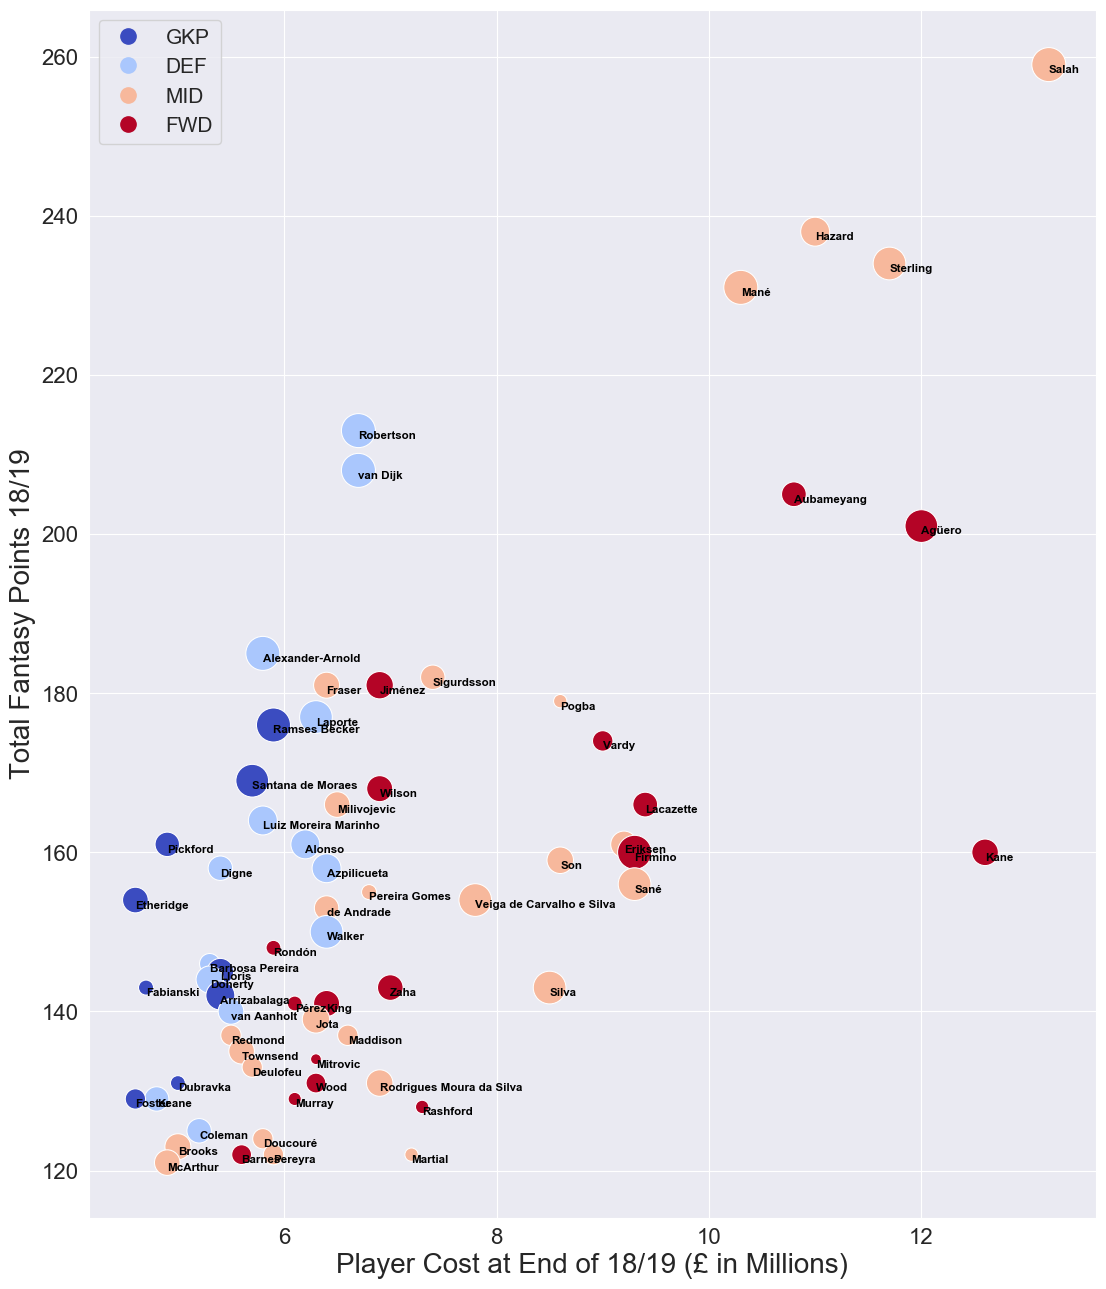

In [33]:
sns.set_style("darkgrid")
fig, ax = plt.subplots(1, 1, figsize = (13, 16), dpi=100)
sns.scatterplot(x='now_cost', y='total_points', hue='element_type', data=top_rows_pts, palette='coolwarm', size=top_rows_pts['team_roi_weight'], sizes=(60, 600))
ax.set_xlabel('Player Cost at End of 18/19 (£ in Millions)', fontsize=20)
ax.set_ylabel('Total Fantasy Points 18/19', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize = 16)
cmap = plt.cm.coolwarm
for line in range(0,top_rows_pts.shape[0]):
    player_color = 'black'
    ax.text(top_rows_pts.now_cost[line], top_rows_pts.total_points[line], 
    top_rows_pts.second_name[line], horizontalalignment='left', verticalalignment='top',
    size='small', color=player_color, weight='bold')
n_positions = len(positions['singular_name_short']) - 1
from matplotlib.lines import Line2D
custom = [Line2D([], [], marker='.', ms=22, color=cmap(0./n_positions), linestyle='None'),
          Line2D([], [], marker='.', ms=22, color=cmap(1./n_positions), linestyle='None'),
          Line2D([], [], marker='.', ms=22, color=cmap(2./n_positions), linestyle='None'),
          Line2D([], [], marker='.', ms=22, color=cmap(3./n_positions), linestyle='None')]
ax.legend(custom, positions['singular_name_short'], fontsize=15)
plt.show()

In [25]:
top_rows_roi = top_rows_roi[:65]
top_rows_roi

,id,photo,web_name,team_code,status,code,first_name,second_name,squad_number,news,now_cost,news_added,chance_of_playing_this_round,chance_of_playing_next_round,value_form,value_season,cost_change_start,cost_change_event,cost_change_start_fall,cost_change_event_fall,in_dreamteam,dreamteam_count,selected_by_percent,form,transfers_out,transfers_in,transfers_out_event,transfers_in_event,loans_in,loans_out,loaned_in,loaned_out,total_points,event_points,points_per_game,ep_this,ep_next,special,minutes,goals_scored,assists,clean_sheets,goals_conceded,own_goals,penalties_saved,penalties_missed,yellow_cards,red_cards,saves,bonus,bps,influence,creativity,threat,ict_index,ea_index,element_type,team,player_roi,team_name
0,88,88734.jpg,Etheridge,97,a,88734,Neil,Etheridge,1.0,,4.6,None,NaN,NaN,0.0,33.5,1,0,-1,0,False,5,10.2,0.0,620408,1095402,0,0,0,0,0,0,154,11,4.1,-1.0,2.0,False,3420,0,0,10,69,0,3,0,2,0,141,18,775,1116.8,21.0,0.0,113.6,0,1,5,33.478261,Cardiff
1,154,111234.jpg,Pickford,11,a,111234,Jordan,Pickford,1.0,,4.9,None,NaN,NaN,0.0,32.9,-1,0,1,0,False,2,13.3,0.0,943768,587424,0,0,0,0,0,0,161,1,4.2,-0.5,4.0,False,3420,0,0,14,46,0,3,0,1,0,94,13,706,776.4,10.0,0.0,78.5,0,1,8,32.857143,Everton
2,245,169187.jpg,Alexander-Arnold,14,a,169187,Trent,Alexander-Arnold,66.0,,5.8,2019-03-20T19:01:21Z,100.0,100.0,0.0,31.9,8,0,-8,0,True,8,26.9,0.0,2611834,3306874,0,0,0,0,0,0,185,15,6.4,1.0,10.8,False,2460,1,13,16,14,0,0,0,3,0,0,25,753,734.4,837.4,276.0,184.7,0,2,12,31.896552,Liverpool
3,247,122798.jpg,Robertson,14,a,122798,Andrew,Robertson,26.0,,6.7,2019-05-07T22:31:21Z,75.0,100.0,0.0,31.8,7,0,-7,0,True,5,33.0,0.0,1723617,2650621,0,0,0,0,0,0,213,6,5.9,0.8,5.8,False,3216,0,12,21,20,0,0,0,4,0,0,29,906,748.8,767.2,318.0,183.6,0,2,12,31.791045,Liverpool
4,246,97032.jpg,van Dijk,14,a,97032,Virgil,van Dijk,4.0,,6.7,2019-03-31T19:31:20Z,100.0,100.0,0.0,31.0,7,0,-7,0,True,4,32.3,0.0,1166867,1851310,0,0,0,0,0,0,208,6,5.5,1.0,9.3,False,3384,4,4,20,22,0,0,0,1,0,0,22,932,993.6,111.1,455.0,156.1,0,2,12,31.044776,Liverpool
5,400,37096.jpg,Fabianski,21,a,37096,Lukasz,Fabianski,1.0,,4.7,2019-02-01T00:01:20Z,100.0,100.0,0.0,30.4,2,0,-2,0,False,3,14.3,0.0,1054458,929168,0,0,0,0,0,0,143,4,3.8,0.0,4.5,False,3420,0,0,7,55,0,1,0,0,0,148,15,742,1136.0,20.0,0.0,115.5,0,1,19,30.425532,West Ham
6,468,116535.jpg,Alisson,14,a,116535,Alisson,Ramses Becker,13.0,,5.9,None,NaN,NaN,0.0,29.8,4,0,-4,0,True,1,23.4,0.0,931671,1257121,0,0,0,0,0,0,176,6,4.6,1.0,6.3,False,3420,0,0,21,22,0,0,0,1,0,76,9,771,677.0,0.1,0.0,67.6,0,1,12,29.830508,Liverpool
7,260,121160.jpg,Ederson,43,a,121160,Ederson,Santana de Moraes,31.0,,5.7,None,NaN,NaN,0.0,29.6,2,0,-2,0,False,2,22.9,0.0,1250973,1512731,0,0,0,0,0,0,169,2,4.4,1.5,7.3,False,3420,0,1,20,23,0,0,0,2,0,58,6,700,535.2,33.0,0.0,56.8,0,1,13,29.649123,Man City
8,484,101188.jpg,Digne,11,a,101188,Lucas,Digne,12.0,,5.4,2019-04-21T14:31:21Z,100.0,100.0,0.0,29.3,4,0,-4,0,False,4,10.2,0.0,1184930,1598581,0,0,0,0,0,0,158,0,4.5,-0.5,7.8,False,2964,4,5,13,38,1,0,0,5,1,0,22,736,883.0,1142.0,300.0,232.7,0,2,8,29.259259,Everton
9,40,90105.jpg,Fraser,91,a,90105,Ryan,Fraser,24.0,,6.4,2019-03-15T10:31:19Z,100.0,100.0,0.0,28.3,9,0,-9,0,False,6,23.7,0.0,2658647,3904067,0,0,0,0,0,0,181,2,4.8,0.0,8.5,False,3165,7,14,9,64,0,0,0,2,0,0,23,751,930.6,1382.4,696.0,301.2,0,3,2,28.281250,Bournemouth


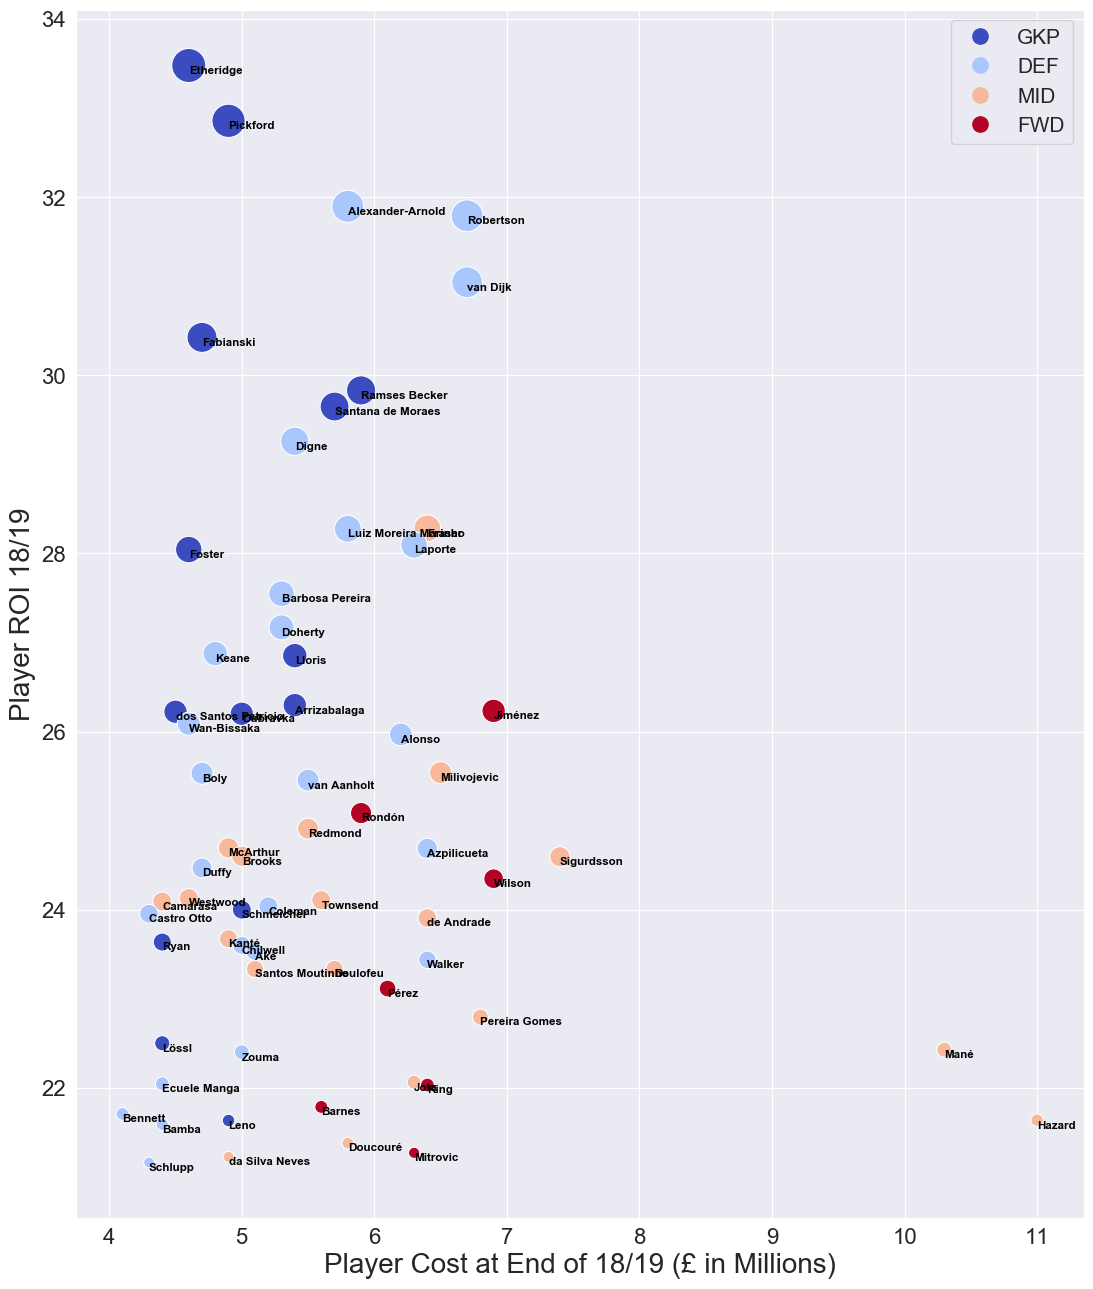

In [32]:
sns.set_style("darkgrid")
fig, ax = plt.subplots(1, 1, figsize = (13, 16), dpi=100)
sns.scatterplot(x='now_cost', y='player_roi', hue='element_type', data=top_rows_roi, palette='coolwarm', size=top_rows_roi['player_roi'], sizes=(60, 600))
ax.set_xlabel('Player Cost at End of 18/19 (£ in Millions)', fontsize=20)
ax.set_ylabel('Player ROI 18/19', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize = 16)
for line in range(0,top_rows_roi.shape[0]):
    player_color = 'black'
    ax.text(top_rows_roi.now_cost[line], top_rows_roi.player_roi[line], 
    top_rows_roi.second_name[line], horizontalalignment='left', verticalalignment='top',
    size='small', color=player_color, weight='bold')
n_positions = len(positions['singular_name_short']) - 1
from matplotlib.lines import Line2D
custom = [Line2D([], [], marker='.', ms=22, color=cmap(0./n_positions), linestyle='None'),
          Line2D([], [], marker='.', ms=22, color=cmap(1./n_positions), linestyle='None'),
          Line2D([], [], marker='.', ms=22, color=cmap(2./n_positions), linestyle='None'),
          Line2D([], [], marker='.', ms=22, color=cmap(3./n_positions), linestyle='None')]
ax.legend(custom, positions['singular_name_short'], fontsize=15)
plt.show()

In [27]:
#TODO: create if block to build team with $100 million